# The Finite Element Method

The finite element method is a procedure for numerically solving systems of differential equations over complex domains. It is often used in Materials Science as a tool for analysing the mechanical, or other physical behaviour of materials. The method works by converting differential equations into algebraic equations, discretising the domain (e.g. the material of interest) into small parts called elements, then finding a solution that minimises the error in satisfying these algebraic equations in each of the elements. Unlike the finite difference methods that we introduced last week, which made use of regular (evenly spaced) discretisations of the domain, the finite element method is very efficient at solving problems with irregular geometries. It can also be used to solve multi-physics problems and so has a huge range of applications. For example, if you wanted to know the stress distribution on an aircraft wing flying at different accelerations and in different temperatures, the finite element method would be the perfect tool to use.

In practice, finite element analysis is often carried out using software such as [Abaqus](https://www.3ds.com/products-services/simulia/products/abaqus/) or [COMSOL](https://www.comsol.com/) (which you will be using in MATS32202 - Corrosion Science and Engineering if you take that module next semester). These packages are very powerful tools that allow you to solve very complex problems; however, it may not be clear to you exactly what they are doing when you use them. The purpose of this week's notebook is to show you the mathematical background behind the finite element method so that you can get an idea of how finite element software packages work. The mathematics in this notebook is advanced and you may find it challenging, but don't worry - you are not going to have to build a finite element code from scratch in the coursework. As long as you can adapt the Python code that we have provided, you should be fine. The most important thing to take away this week is the knowledge that whenever you use a package such as Abaqus or Comsol, there is a lot of mathematics going on behind the scenes.

No further reading is required for this course; however, this week's material was largely developed with the help of the [<code>oomph-lib</code>](http://oomph-lib.maths.man.ac.uk/doc/html/index.html) [finite element method documentation](http://oomph-lib.maths.man.ac.uk/doc/intro/html/index.html). This documentation provides further details that are omitted here. <code>oomph-lib</code> is an object-oriented, open-source finite-element library for the simulation of multi-physics problems that was developed here at the University of Manchester. It is free to download and use, but requires fluency in [C++](https://en.wikipedia.org/wiki/C%2B%2B) to make use of to its greatest potential.

## Mathematical Background

The finite element method builds upon some important concepts, therefore we shall discuss these before moving onto the method itself. In turn, we shall consider:
1. Newton's method for finding the roots of an equation numerically
2. Index notation for vectors and matrices
3. Integration by parts
4. The concept of a so-called "weak" solution to a differential equation
5. The Galerkin method - a method for numerically solving differential equations that is named after [Boris Galerkin](https://en.wikipedia.org/wiki/Boris_Galerkin) (despite the fact it was discovered by [Walther Ritz](https://en.wikipedia.org/wiki/Walther_Ritz)!) - upon which the finite element method depends.

First, however, we shall take another look at Poisson's equation, which we will use as an example to apply the finite element method to.

### Poisson's Equation Revisited

In this notebook, we will use the finite element method to solve Poission's equation in one dimension as it is a nice example of a simple differential equation:

$$\frac{d^2u(x)}{dx^2}=f(x),$$

where $f(x)$ is a given function. As we discussed last week, Poisson's equation can be used to model steady diffusion processes such as temperature diffusion through a metal rod. We mentioned that for simple choices of $f(x)$, Poisson's equation can be solved analytically. For example, if $f(x)=6x$, we have

$$\frac{d^2u(x)}{dx^2}=6x\implies u(x)=x^3+Ax+B,$$

where $A$ and $B$ are constants. We then applied initial conditions at one end of the rod to determine the values of these constants. We needed two conditions in order to determine the two constants and so we needed to know the values of both $u$ and its derivative at that end (i.e. $u(0)=u_0$ and $u'(0)=v_0$). These initial conditions together with the governing equation are called an initial value problem. Sometimes, however, we will not know the value of the derivative at one end, but we might know something about the other end of the rod. For example, if our rod is of length 1 and we know the temperature at its ends e.g. it is 300 K at one end and 299 K at the other, then we have the conditions:

$$u(0)=300,~u(1)=299.$$

These are called boundary conditions (because they tell us about the state of the rod on its boundary) and together with the governing equation they form a boundary value problem. The boundary conditions can be applied to determine $A$ and $B$:

$$u(0)=300\implies B=300,$$
$$u(1)=299\implies1+A+300=299\implies A=-2,$$
$$\implies u(x)=x^3-2x+300.$$

The methods we introduced last week can only be used for solving initial value problems problems in the form we presented them; however, the finite element method can be used to solve boundary value problems. We can write the equation and boundary conditions more generally as

$$\frac{d^2u(x)}{dx^2}=f(x),~\hspace{1cm}~u(0)=g_0,~u(1)=g_1,$$

where $f(x)$ is a given function and $g_0$ and $g_1$ are given constants. In order to implement the finite element method, we write the governing equation in "residual form" by moving all the terms on the right side to the left. Therefore, our boundary value problem is written as

$$\mathcal{R}(x,u(x))=\frac{d^2u(x)}{dx^2}-f(x)=0,~\hspace{1cm}~u(0)=g_0,~u(1)=g_1,$$

which we shall call _Problem P1_. We have introduced $\mathcal{R}$ as a general notation to describe the whole equation (more formally, $\mathcal{R}$ is a differential operator acting on $x$ and $u$). This general notation is useful because we can replace the definition of $\mathcal{R}(x,u(x))$ with any other differential equation (even higher-order and partial differential equations) and the methodology presented below will still be valid. For example, we could let

$$\mathcal{R}(t,u(t))=\frac{du(t)}{dt}-\lambda u(t)-f(t),~\hspace{1cm}~\text{with}~\hspace{1cm}~u(0)=g_0,$$

in order to solve the time-dependent heat transfer problem we introduced last week. A more compact notation for the boundary conditions is

$$u|_{\partial D}=g,$$

where the notation $|_{\partial D}$ means that $u$ is evaluated on the boundary $\partial D$ of the domain $D$. We shall use this short-hand notation frequently below.

#### <span style="color: red"> Task 1:</span> Solve Poisson's equation with $f(x)=6x$, $u(0)=g_0=0$ and $u(1)=g_1=1$ analytically.

We shall return to Poisson's equation when we get to the Galerkin method, below.

### Newton's Method

Newton's method is a technique for numerically determining the roots of an equation. In other words, the values of $x$ that satisfy

$$f(x)=0,$$

for some known $f(x)$. For some instances of $f(x)$, the roots can be found exactly. For example, if $f(x)=x^2-1$, then the roots of the equation are $x=1$ and $x=-1$. However, for other instances of $f(x)$ (e.g. $f(x)=x-e^{-x}$), we can only find approximate solutions. It is for these kinds of equations that we need methods such as Newton's method.

The method works by making an initial "guess" for one of the roots, which we shall call $x_0$, then calculating an improved approximation $x_1$ given by the equation

$$x_1=x_0-\frac{f(x_0)}{f'(x_0)},$$

where $f(x_0)$ is called the residual of $f$ at $x_0$. You can then iteratively apply this technique to obtain increasingly more accurate approximations to the root via the equation

$$x_{i+1}=x_i-\frac{f(x_i)}{f'(x_i)},\hspace{1cm}i=0,1,2,....$$

Basically, the method works by following the tangent of the curve at your initial guess and finding where the tangent crosses the $x$-axis. Each time you follow a new tangent you get a bit closer to the true value of the root. This is [illustrated nicely](https://en.wikipedia.org/wiki/Newton%27s_method#/media/File:NewtonIteration_Ani.gif) on the [Wikipedia page for Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method). Effectively, we are adding a correction term

$$\delta x=-\frac{f(x)}{f'(x)}$$ 

to our initial guess at each step so that $x$ is replaced with $x+\delta x.$ Let's illustrate this method to find a root of the equation

$$x-e^{-x}=0.$$

We will start by plotting this function along with an initial guess for the root of $x_0=0.5$:

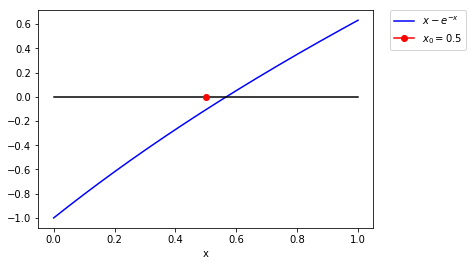

In [1]:
import numpy as np #import numpy
import matplotlib.pyplot as plt #import pyplot from matplotlib as plt
x=np.linspace(0,1,301) #create a list of input x values
%matplotlib inline 
#define where plots will appear

plt.plot(x,x-np.exp(-x),'-b', label="$x-e^{-x}$") #plot f(x)=x-exp(-x)
plt.plot(x,x*0,'-k') #plot horizontal axis f(x)=0
plt.plot([0.5],[0],'o-r', label="$x_0=0.5$") #plot initial guess
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

We then calculate an improved approximation. For this instance of $f(x)$, we have

$$f'(x)=1+e^{-x},$$

therefore our improved guess will be

$$x_1=0.5-\frac{0.5-e^{-0.5}}{1+e^{-0.5}}\approx0.566.$$

Let's zoom in to the region $x\in(0.4,0.6)$ and plot the improved approximation:

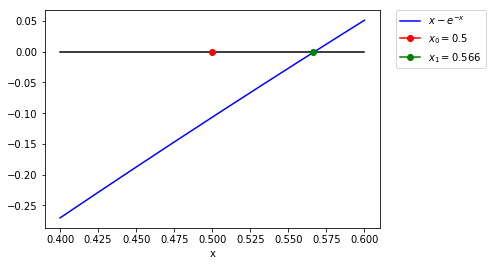

In [2]:
x0=0.5
x1=x0-(x0-np.exp(-x0))/(1+np.exp(-x0))
x=np.linspace(0.4,0.6,301) #create a list of input x values
plt.plot(x,x-np.exp(-x),'-b', label="$x-e^{-x}$") #plot f(x)=x-exp(-x)
plt.plot(x,x*0,'-k') #plot horizontal axis f(x)=0
plt.plot([x0],[0],'o-r', label="$x_0=0.5$") #plot initial guess
plt.plot([x1],[0],'o-g', label="$x_1=0.566$") #plot improved approximation
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

This is clearly an improvement, but if we zoom in even further to the region $x\in(0.56,0.57)$, there is still some inaccuracy:

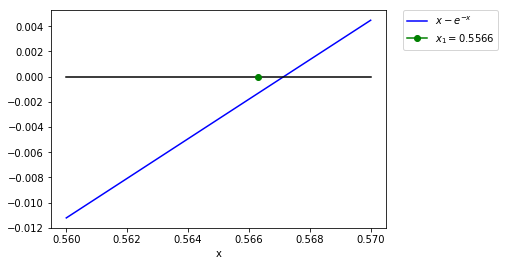

In [3]:
x=np.linspace(0.56,0.57,301) #create a list of input x values
plt.plot(x,x-np.exp(-x),'-b', label="$x-e^{-x}$") #plot f(x)=x-exp(-x)
plt.plot(x,x*0,'-k') #plot horizontal axis f(x)=0
plt.plot([x1],[0],'o-g', label="$x_1=0.5566$") #plot improved approximation
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

Luckily, we can just keep going until we reach a required level of accuracy:

$$x_2=0.566-\frac{0.566-e^{-0.566}}{1+e^{-0.566}}\approx0.567.$$

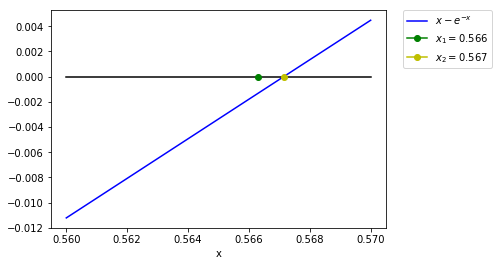

In [4]:
x2=x1-(x1-np.exp(-x1))/(1+np.exp(-x1))
plt.plot(x,x-np.exp(-x),'-b', label="$x-e^{-x}$") #plot f(x)=x-exp(-x)
plt.plot(x,x*0,'-k') #plot horizontal axis f(x)=0
plt.plot([x1],[0],'o-g', label="$x_1=0.566$") #plot improved approximation
plt.plot([x2],[0],'o-y', label="$x_2=0.567$") #plot improved approximation
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

We can keep going, finding better and better solutions at each step. We stop once the maximum error in the solution is below a certain prescribed tolerance, which we call <code>tol</code>. We can conveniently code up this method and get it to keep going until the error is below <code>tol</code> using a <code>while</code> loop:

In [5]:
tol=0.0000001 #our prescribed tolerance
xsol=0.5 #our initial guess for the solution is x=0.5, as above
error=abs(xsol-np.exp(-xsol)) #our error measure is the absolute value of f(x) (i.e. its deviation from 0)
n=0 #n will count how many steps we have taken

while (error>tol): #now we set up our while loop
    n=n+1 #for each iteration, n increases by 1
    xsol=xsol-(xsol-np.exp(-xsol))/(1+np.exp(-xsol)) #calculate an improved guess
    error=abs(xsol-np.exp(-xsol)) #calculate the updated error measure
    
print('Our calculated root is at x=',"%.6g" % xsol)
print('The algorithm took', n,'steps')

Our calculated root is at x= 0.567143
The algorithm took 3 steps


#### <span style="color: red"> Task 2:</span> Find a root of the equation $x-\cos(x)=0$ using Newton's method

In this case $f(x)=x-\cos(x)$. You will need to calculate $f'(x)$.

Hint: try plotting $f(x)$ first to choose a reasonable initial guess.

### Index notation for vectors and matrices

To implement the finite element method, we will need to deal with vectors and matrices. In standard mathematical notation, these are repesented by bold lower case and non-bold upper case letters respectively. For example we could have the vector $\mathbf{a}$ of length $n$ and the matrix $\text{A}$ of size $m\times n$:

$$\mathbf{a}=\left(\begin{array}{c}
a_1\\
a_2\\
\vdots\\
a_n
\end{array}\right),\hspace{1cm}\text{A}=\left(\begin{array}{cccc}
A_{11} & A_{12} & \cdots & A_{1n}\\
A_{21} & A_{22} & \cdots & A_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
A_{m1} & A_{m2} & \cdots & A_{mn}\\
\end{array}\right).$$

A compact way to write the entries of this vector and matrix is to use index notation:

$$a_i\hspace{0.5cm}\text{for}\hspace{0.5cm}i=1,2,...,n,\hspace{1cm}\text{and}\hspace{1cm}A_{ij}\hspace{0.5cm}\text{for}\hspace{0.5cm}\begin{array}{l}
i=1,2,...,m,\\
j=1,2,...,n.
\end{array}$$

We should note, however, that this numbering convention (running from 1 to $n$) is contrary to the Python numbering convention, which runs from 0 to $n-1$. Therefore, if we wanted to select the 3$^\text{rd}$ element of the vector $\mathbf{a}$, which is $a_3$, in Python we would need to write <code>a[2]</code>. Similarly, to select the (3,4) entry of the matrix $\text{A}$, which is $A_{34}$, in Python we would need to write <code>A[2,3]</code>. You need to bear this in mind when trying to understand some of the code below.

Vectors and matrices can be input into Python using a <code>numpy array</code>. For example, the vector $\mathbf{a}=(1,2,5)$ and the matrix 

$$\text{A}=\left(\begin{array}{ccc}
-1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{array}\right)$$

can be input as follows:

In [6]:
a=np.array([1,2,5]) #input a
A=np.array([[-1,2,3],[4,5,6],[7,8,9]]) #input A
print(a) #print a
print(A) #print A

[1 2 5]
[[-1  2  3]
 [ 4  5  6]
 [ 7  8  9]]


#### <span style="color: red"> Task 3:</span> Input the vectors $\mathbf{b}=(1,2,3)$ and $\mathbf{c}=(4,5,6)$ into Python, then calculate the value of $\frac{b_3c_1}{b_2}$.

We can write matrix equations using index notation:

$$\text{A}\cdot\mathbf{x}=\mathbf{a}\hspace{1cm}\text{becomes}\hspace{1cm}\sum_{j=1}^{n}A_{kj}x_j=a_k,\hspace{1cm}\text{for}\hspace{1cm}k=1,2,...,m.$$

It is very quick and easy to solve matrix equations in Python. For example, if we wanted to solve this equation for $\mathbf{x}$ using the definitions of $\text{A}$ and $\mathbf{a}$ we input above, we simply use this code:

In [7]:
x=np.linalg.solve(A,a) #solve the matrix equation A.x=a for x
print('x =',x) #print the solution

x = [-1.  6. -4.]


#### <span style="color: red"> Task 4:</span> Solve the matrix equation $\text{B}\cdot\mathbf{y}=\mathbf{b}$ for $\mathbf{y}$ using the $\mathbf{b}$ you input in Task 3 with 

$$\text{B}=\left(\begin{array}{ccc}
-1 & 2 & 1\\
2 & 1 & 1\\
1 & 2 & 3
\end{array}\right).$$

We can also set up some special matrices using index notation, one important example of which is the Jacobian matrix. Imagine you had several functions $f_1$, $f_2$, ... $f_n$, each of which is a function of several variables $x_1$, $x_2$, ... $x_n$ and we were interested in all of the derivatives of these functions. We can set up a matrix that gives all of these derivatives:

$$\text{J}=\left(\begin{array}{cccc}
\dfrac{\partial f_1}{\partial x_1} & \dfrac{\partial f_1}{\partial x_2} & \cdots & \dfrac{\partial f_1}{\partial x_n}\\
\dfrac{\partial f_2}{\partial x_1} & \dfrac{\partial f_2}{\partial x_2} & \cdots & \dfrac{\partial f_2}{\partial x_n}\\
\vdots & \vdots & \ddots & \vdots\\
\dfrac{\partial f_n}{\partial x_1} & \dfrac{\partial f_n}{\partial x_2} & \cdots & \dfrac{\partial f_n}{\partial x_n}\\
\end{array}\right).$$

This is the Jacobian matrix and it can be written in index notation as

$$J_{ij}=\frac{\partial f_i}{\partial x_j}\hspace{1cm}\text{for}\hspace{1cm}\begin{array}{l}
i=1,2,...,n,\\
j=1,2,...,n.
\end{array}$$

Let's say we had

$$\begin{array}{C}
f_1(x_1,x_2,x_3)=-x_1+\sqrt{x_2},\\
f_2(x_1,x_2,x_3)=\dfrac{1}{2x_2}+2\sin(x_3),\\
f_3(x_1,x_2,x_3)=x_1+2x_3,\\
\end{array}$$

then the Jacobian matrix would be given by

$$\text{J}=\left(\begin{array}{ccc}
-1 & \dfrac{1}{2\sqrt{x_2}} & 0\\
0 & -\dfrac{1}{2x_2^2} & 2\cos(x_3)\\
1 & 0 & 2
\end{array}\right).$$

#### <span style="color: red"> Task 5:</span> Calculate the Jacobian matrix for

$$\begin{array}{C}
f_1(x_1,x_2,x_3)=x_1^3+e^{x_2}-x_3,\\
f_2(x_1,x_2,x_3)=x_1x_2+\cos(x_3),\\
f_3(x_1,x_2,x_3)=x_1+x_3.\\
\end{array}$$

#### Using the Jacobian matrix to apply Newton's method in higher dimensions

Suppose we want to know the roots of the functions $f_1$, $f_2$, ..., $f_n$. It turns out we can extend Newton's method in one dimension (as presented above) to higher dimensions using the Jacobian matrix. Whereas in one dimension, we wanted to find a root $x$ that satisfied $f(x)=0$, if we have $n$ functions of $n$ variables, then we are looking for the values of $x_1$, $x_2$, ..., $x_n$ that satisfy

$$\begin{array}{c}
f_1(x_1,x_2,...,x_n)=0,\\
f_2(x_1,x_2,...,x_n)=0,\\
\vdots\\
f_n(x_1,x_2,...,x_n)=0.\\
\end{array}$$

We can write this system in vector form - we are looking for the values of the vector $\mathbf{x}$ that satisfy the vector equation

$$\mathbf{f}(\mathbf{x})=\mathbf{0}.$$

In one dimension, we made an initial guess for the root $x$ and then improved it by adding

$$\delta x=-\frac{f(x)}{f'(x)},$$

so that our improved approximation to the root was $x+\delta x$. Rearranging this equation, we see that $\delta x$ satisfies

$$f'(x)\delta x=-f(x).$$ 

In $n$ dimensions, this equation is replaced by

$$\text{J}\cdot\delta\mathbf{x}=-\mathbf{f}(\mathbf{x}),$$

where $\text{J}$ is the Jacobian matrix introduced above. We need to solve this matrix equation for $\delta\mathbf{x}$ and then our improved approximation for the solution $\mathbf{x}$ will be $\mathbf{x}+\delta\mathbf{x}$. In index notation, this equation is written as

$$\sum_{j=1}^nJ_{kj}x_j=-f_k,~\hspace{1cm}~\text{where}~\hspace{1cm}k=1,...,n.$$

Let's find a root of the system 

$$\begin{array}{C}
f_1(x_1,x_2,x_3)=0,\\
f_2(x_1,x_2,x_3)=0,\\
f_3(x_1,x_2,x_3)=0,\\
\end{array}$$

where $f_1$, $f_2$ and $f_3$ are the functions we introduced above. We simply make an initial guess for our solution (let's choose $\mathbf{x}=(1,1,1)$) then solve the matrix equation above using the Jacobian matrix we previously calculated and finally calculate a new solution via $\mathbf{x}\rightarrow\mathbf{x}+\delta\mathbf{x}$:

In [8]:
x=np.array([1,1,1]) #our initial guess
f=np.array([-x[0]+x[1]**(1/2),1/(2*x[1])+2*np.sin(x[2]),x[0]+2*x[2]]) #the values of f at x  (i.e. the residuals)
J=np.array([[-1,1/(2*x[1]**(1/2)),0],[0,-1/(2*x[1]**2),2*np.sin(x[2])],[1,0,2]]) #input the Jacobian matrix calculated above
deltax=np.linalg.solve(J,-f) #solve the matrix equation J.deltax=-f for deltax
x=x+deltax #calculate an improved approximation to the root
print('x =',x) #print the improved approximation

x = [ 0.81456619  0.62913238 -0.40728309]


We can then see how well $\mathbf{x}$ solves our system by calculating the residual vector $\mathbf{r}=\mathbf{f}(\mathbf{x})$. The closer this quantity is to $\mathbf{0}$, the better our solution is:

In [9]:
f=np.array([-x[0]+x[1]**(1/2),1/(2*x[1])+2*np.sin(x[2]),x[0]+2*x[2]]) #the values of f at x
print('The residual vector is',f) #print the residual vector

The residual vector is [-2.13875348e-02  2.51304490e-03 -6.66133815e-16]


As you can see, all of the residuals are small, so we have a good approximation to the solution. If we wanted to continue and obtain an even better solution (until all of the residuals are below $10^{-8}$, say) then we could use another <code>while</code> loop:

In [10]:
x=np.array([1,1,1]) #our initial guess
f=np.array([-x[0]+x[1]**(1/2),1/(2*x[1])+2*np.sin(x[2]),x[0]+2*x[2]]) #the values of f at x (i.e. the residuals)
tol=0.00000001 #our tolerance
maxres=max(abs(f)) #calculate the maximum entry in the residual vector

while (maxres>tol): #set up while loop
    J=np.array([[-1,1/(2*x[1]**(1/2)),0],[0,-1/(2*x[1]**2),2*np.sin(x[2])],[1,0,2]]) #input the Jacobian matrix calculated above
    deltax=np.linalg.solve(J,-f) #solve the matrix equation J.deltax=-f for deltax
    x=x+deltax #calculate an improved approximation to the root
    f=np.array([-x[0]+x[1]**(1/2),1/(2*x[1])+2*np.sin(x[2]),x[0]+2*x[2]]) #the values of f at x (i.e. the residuals)
    maxres=max(abs(f)) #calculate the maximum entry in the residual vector
    
print('x =',x) #print the improved approximation
print('The residual vector is',f) #print the final residuals

x = [ 0.80084058  0.64134563 -0.40042029]
The residual vector is [ 0.0000000e+00 -9.3322905e-09  0.0000000e+00]


#### <span style="color: red"> Task 6:</span> Find a root of the system 

$$\begin{array}{C}
f_1(x_1,x_2,x_3)=0,\\
f_2(x_1,x_2,x_3)=0,\\
f_3(x_1,x_2,x_3)=0,\\
\end{array}$$

with $f_1$, $f_2$ and $f_3$ defined as they were in Task 5. Iterate your solution until the maximum residual is less than $10^{-10}$.

### Integration By Parts

Another trick we will need to use below is integration by parts. You should have come across this before, but for reference here is a statement of the rule for arbitrary functions $u(x)$ and $v(x)$:

$$\int_a^bu(x)v'(x)dx=[u(x)v(x)]_a^b-\int_a^bu'(x)v(x)dx.$$

So, for example, if we wanted to integrate $x\cos(x)$ between 0 and $\pi$, we could choose $u(x)=x$, $v'(x)=\cos(x)\Rightarrow v(x)=\sin(x)$ to obtain

$$\int_0^\pi x\cos(x)dx=[x\sin(x)]_0^\pi-\int_0^\pi\sin(x)dx=-2$$

#### <span style="color: red"> Task 7:</span> Integrate $x^2\sin(x)$ between 0 and $\pi$ by parts.

### The Weak Solution

The finite element method depends upon the concept of the weak solution to the differential equation you wish to solve. A strong solution to a boundary value problem is the classical solution that we are used to - i.e. it is the function $u(x)$ that satisfies the equation and boundary conditions at every point in the domain you are interested in. A weak solution, however, only satisfies the governing equations in an average sense. It is defined as the function $u_w$ that satisfies the boundary conditions:

$$u_w|_{\partial D}=g,$$

and for which the "weighted residual", defined as

$$r=\int\mathcal{R}(x,u_w(x))\phi(x)dx$$

is equal to 0 for _any_ function $\phi(x)$ (this is called the test function) that satisfies homogeneous boundary conditions (i.e. boundary conditions with $g=0$):

$$\phi|_{\partial D}=0.$$

So for Problem P1, we would seek the solution $u_w(x)$ that satifies the equation

$$r=\int\left(\frac{d^2u_w(x)}{dx^2}-f(x)\right)\phi(x)dx=0,$$

for any $\phi(x)$ that satifies the homogeneous boundary conditions $\phi(0)=\phi(1)=0$. We shall call this _Problem P1 Weak_.

You may be sceptical about whether the weak solution is of any use, but it transpires that _a weak solution is a strong solution_ (i.e. $u_w=u$)! We shall not go into the reasons why here, but if you would like an intuitive explanation, see the [<code>oomph-lib</code> finite element method documentation](http://oomph-lib.maths.man.ac.uk/doc/intro/html/index.html). Therefore, if we can find a $u_w$ for which $r=0$ for any $\phi(x)$, then we have found a solution to our boundary value problem! It is probably not obvious why writing our problem in this form is helpful, but essentially it is a mathematical trick that allows us to make progress because the techniques that we use below can be applied to Problem P1 Weak, but cannot be applied directly to Problem P1.

### The Galerkin Method

The Galerkin method is a technique for turning a differential equation into a discrete problem and the finite element method builds upon this method. This section is mathematically challenging, but as mentioned above, don't worry if you don't follow all the details, just make sure you know which parts of the code to edit when we get to it. We shall use the Galerkin method to solve a general boundary value problem in weak form. We start by spliting $u$ into two parts:

$$u(x)=u_p(x)+u_h(x),$$

where $u_p$ is an arbitrary function that satisfies the boundary conditions:

$$u_p|_{\partial D}=g$$

and therefore the unknown function $u_h$ must satisfy the homogeneous boundary conditions:

$$u_h|_{\partial D}=0.$$

We then expand $u_h$ in terms of a set of basis functions $\psi_j(x),~j=1,2,...$ so that we can write

$$u_h(x)=\sum_{j=1}^\infty U_j\psi_j(x),$$

where the $U_j$ are unknown constants. [Basis functions](https://en.wikipedia.org/wiki/Basis_function) are sets of simple functions that any other function can be written as a linear combination of. There are many types of functions that can be used as basis functions, such as polynomials and trigonometric functions and $\psi_j$ can be chosen to be any of these provided they satisfy the homogeneous boundary conditions. Using this expansion, we can write the total solution as

$$u(x)=u_p(x)+\sum_{j=1}^\infty U_j\psi_j(x).$$

We can then substitute this into our expression for the weighted residual to obtain

$$r=\int\mathcal{R}\left(x,u_p(x)+\sum_{j=1}^\infty U_j\psi_j(x)\right)\phi(x)dx,$$

or for Problem P1 Weak:

$$r=\int_0^1\left(\frac{d^2u_p(x)}{dx^2}+\sum_{j=1}^\infty U_j\frac{d^2\psi_j(x)}{dx^2}-f(x)\right)\phi(x)dx.$$

We then also expand $\phi(x)$ in terms of the same basis:

$$\phi(x)=\sum_{k=1}^\infty \Phi_k\psi_k(x),$$

which allows us to write

$$r=\sum_{k=1}^\infty\Phi_kr_k(U_1,U_2,...)=0,$$

where

$$r_k(U_1,U_2,...)=\int\mathcal{R}\left(x,u_p(x)+\sum_{j=1}^\infty U_j\psi_j(x)\right)\psi_k(x)dx,$$

or for Problem P1 Weak:

$$r_k(U_1,U_2,...)=\int_0^1\left(\frac{d^2u_p(x)}{dx^2}+\sum_{j=1}^\infty U_j\frac{d^2\psi_j(x)}{dx^2}-f(x)\right)\psi_k(x)dx.$$

The condition that the weighted residual must equal zero for any test function $\phi(x)$ is equilavent to saying that it must equal zero for any values of the coefficients $\Phi_k$. Therefore, the only way this will happen is if

$$r_k(U_1,U_2,...)=0~\hspace{1cm}~\text{for}~\hspace{1cm}~k=1,2,....$$

Although the expansions above are expressed as infinite sums, in practice, we can take a finite number of terms and still obtain a good approximation to the function we are interested in. The approximations truncated after $M$ terms look like this:

$$\bar{u}(x)=u_p(x)+\sum_{j=1}^M U_j\psi_j(x)~\hspace{1cm}~\text{and}~\hspace{1cm}~\bar{\phi}(x)=\sum_{k=1}^M\Phi_k\psi_k(x),$$

and we can determine the $M$ unknown coefficients $U_1,U_2,...,U_M$ by solving the $M$ algebraic equations

$$r_k(U_1,...,U_M)=0,~\hspace{1cm}~\text{where}~\hspace{1cm}~k=1,2,...,M.$$

An algorithm for this process is as follows:

#### Algorithm 1: The Galerkin method

This algorithm depends upon Newton's method in $M$ dimensions. We are looking for the roots of each of the functions $r_k$ (i.e. the values of $U_1,U_2,...,U_M$) for which $r_k=0$, therefore this is an appropriate method to use.

1. Provide an initial guess for the unknowns $U_1,U_2,...,U_M$.
2. Evaluate the residuals $r_k$ for $k=1,2,...,M$.
3. Calculate a suitable measure of the size of the residual vector. For example, we may want to look at the maximum absolute value of any $r_k$. We want this number to be as small as possible. The smaller the number, the better our approximation is to the true solution. If $r_k$ is below some prescribed tolerence level, then we accept the $U_1,U_2,...,U_M$ as our solution. Otherwise, we move onto step 4:
4. Calculate the Jacobian matrix that gives the derivatives of the residuals, $r_k$ with repsect to the variables $U_j$: $$J_{kj}=\left.\frac{\partial r_k}{\partial U_j}\right|_{(U_1,U_2,...,U_M)}~\hspace{1cm}~\text{for}~j,k=1,2,...,M.$$ From the definition of $r_k$ for Problem P1 Weak, we can see that in this case we have $$J_{kj}=\frac{\partial r_k}{\partial U_j}=\int_0^1\frac{\partial^2\psi_j(x)}{\partial x^2}\psi_k(x)dx.$$
5. Solve the linear system $$\sum_{j=1}^MJ_{kj}\delta U_j=-r_k,~\hspace{1cm}~\text{where}~\hspace{1cm}k=1,...,M,$$ for $\delta U_j,~(j=1,...,M)$. This system can be written in matrix form as follows: $$\text{J}\cdot\mathbf{\delta U}=-\mathbf{r},$$ where $J$ is the matrix whose entries are $J_{kj}$, $\mathbf{\delta U}$ is the vector whose entries are $\delta U_j$ and $\mathbf{r}$ is the vector whose entries are $r_k$.
6. Compute an improved approximation to the solution via $$U_j=U_j+\delta U_j~\hspace{1cm}~\text{for}~\hspace{1cm}~j=1,2,...,M.$$
7. Go to 2.

#### Python Implementation

Below is an implementation of this algorithm in Python for Problem P1 Weak over the range $x=0$ to $x=1$, with $f(x)=6x$, $u(0)=g_0=300$, $u(1)=g_1=299$ and $M=10$. We shall choose a set of trigonometric functions as our basis functions:

$$\psi_j(x)=\sin(\pi jx),$$

which gives

$$\frac{d^2\psi_j(x))}{dx^2}=-(\pi j)^2\sin(\pi jx).$$

Note that these basis functions are appropriate because they satisfy the homogeneous boundary conditions $\psi_j(0)=\psi_j(1)=0$. We also need to choose an arbitrary function that satisfies the non-homogeneous boundary conditions. We shall choose

$$u_p(x)=g_0+(g_1-g_0)x,$$

which we can see satisfies $u_p(0)=g_0$ and $u_p(1)=g_1$ and gives

$$\frac{d^2u_p(x)}{dx^2}=0.$$

For Problem P1 Weak, we have

$$u_p(x)=300+(299-300)x=300-x.$$

Substituting these choices for $f(x)$, $\psi_j(x)$ and $u_p(x)$ into the equation for $r_k$, we obtain

$$r_k(U_1,U_2,...)=\int_0^1\left(-\sum_{j=1}^M U_j(\pi j)^2\sin(\pi jx)-6x\right)\sin(\pi kx)dx,$$

which we can rewrite as

$$r_k(U_1,U_2,...)=-\sum_{j=1}^M\int_0^1U_j(\pi j)^2\sin(\pi jx)\sin(\pi kx)dx-\int_0^16x\sin(\pi kx)dx.$$

We also have

$$\frac{\partial r_k}{\partial U_j}=-\int_0^1(\pi j)^2\sin(\pi jx)\sin(\pi kx)dx=
\left\{\begin{array}{cc}
-(\pi j)^2/2, & j=k,\\
0, & j\ne k,
\end{array}\right.$$

which allows us to simplify steps 4 and 5 of Algorithm 1 to

$$\delta U_k=\frac{2r_k^{(i)}}{(\pi k)^2},~\hspace{1cm}~\text{for}~\hspace{1cm}~j=1,2,...,M.$$

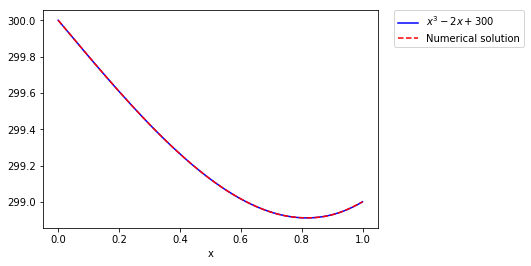

In [11]:
import scipy.integrate as integrate #import numerical integration functionality from scipy
M=10 #set value for M
tol=0.0000001 #set tolerance for the maximum error we will allow

#Algorithm Step 1:
U=np.ones(M) #set initial guesses for U1,...UM. We have chosen to Uj=1 for all j=1,2,...,M

#Set up while loop - the algorithm will loop over Steps 2-7 until the maximum residual is less than the tolerance
maxres=tol+1 #set initial value for the maximum resiual
while (maxres>tol): #the condition for the while loop

#Algorithm Step 2:
    r=np.zeros(M) #create a vector of zeros of length M for the residuals rk. We only do this so that r has the right length
    myint=np.zeros(M) #create a vector of zeros of length M for the first set of integrals, which will be summed over
    Mrange=range(M) #create a list of integers between 0 and M-1
    for k in Mrange: # loop over k between 0 and M-1
        for j in Mrange: # loop over j between 0 and M-1
            myint[j]=integrate.quad(lambda x: U[j]*((np.pi*(j+1))**2)*np.sin(np.pi*(j+1)*x)*np.sin(np.pi*(k+1)*x),0,1)[0] #calculate the set of integrals to be summed over
        r[k]=-sum(myint)-integrate.quad(lambda x: 6*x*np.sin(np.pi*(k+1)*x),0,1)[0] #calculate rk

#Algorithm Step 3:
    maxres=max(abs(r)) #calculate the maximum residual
    
#Algorithm Steps 4 and 5:    
    deltaU=np.zeros(M) #create a vector of zeros of length M for deltaU. We only do this so that deltaU has the right length
    for k in Mrange: #loop over k between 0 and M-1
        deltaU[k]=2*r[k]/(np.pi*(k+1))**2 #calculate deltaU
        
#Algorithm Step 6:        
    U=U+deltaU #calculate the new value of U
    
#Calculate the final answer:    
    
def FinalU(x,U): #define a function that outputs our final answer
    output=np.zeros(len(x)) #create a vector of zeros of that is the same length as the input vector x. We only do this so that the output has the right length
    SinList=np.zeros(len(U)) #create a vector of zeros of that is the same length as U. We only do this so that the SinList has the right length
    for j in range(len(x)): # loop over j between 0 and (the length of x)-1
        for k in range(len(U)): # loop over k between 0 and (the length of U)-1
            SinList[k]=np.sin(np.pi*(k+1)*x[j]) #the kth basis function
        output[j]=300-x[j]+sum(U*SinList) #the final answer - the first part (300-x[j]) is Up(x), the second is the sum over Uj times the basis functions
    return output #return the output

x=np.linspace(0,1,301) #create a list of input x values

plt.plot(x,x**3-2*x+300,'-b', label="$x^3-2x+300$") #plot f(x)=x^3-2x+300
plt.plot(x,FinalU(x,U),'--r', label="Numerical solution") #plot numerical solution
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

So that you can get an idea of which parts of the code do what, below is another implementation of the Galerkin method to solve Poission's equation, but this time, we will use $f(x)=\cos(x)$, $u(0)=g_0=1$ and $u(1)=g_1=2$. Therefore, our arbitrary function for the boundary conditions will be

$$u_p(x)=1+x.$$

The exact solution in this case is

$$u(x)=2+\cos(1)x-\cos(x).$$

We will use the same basis functions:

$$\psi_j(x)=\sin(\pi jx),$$

but will truncate our series expansions after $M=20$ terms this time. Look for differences between the code below and that above, to work out which bits do what.

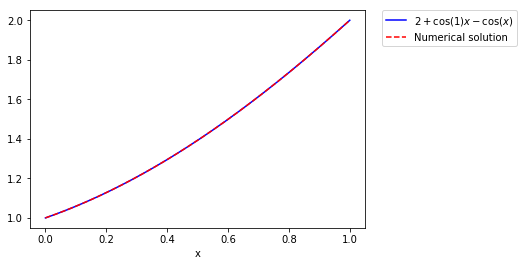

In [12]:
M=20 #this time M=20
tol=0.0000001

#Algorithm Step 1:
U=np.ones(M)

#Set up while loop
maxres=tol+1 
while (maxres>tol):

#Algorithm Step 2:
    r=np.zeros(M)
    myint=np.zeros(M)
    Mrange=range(M)
    for k in Mrange: 
        for j in Mrange: 
            myint[j]=integrate.quad(lambda x: U[j]*((np.pi*(j+1))**2)*np.sin(np.pi*(j+1)*x)*np.sin(np.pi*(k+1)*x),0,1)[0]
        r[k]=-sum(myint)-integrate.quad(lambda x: np.cos(x)*np.sin(np.pi*(k+1)*x),0,1)[0] #we have changed 6x to cos(x)

#Algorithm Step 3:
    maxres=max(abs(r))
    
#Algorithm Steps 4 and 5:    
    deltaU=np.zeros(M) 
    for k in Mrange: 
        deltaU[k]=2*r[k]/(np.pi*(k+1))**2
        
#Algorithm Step 6:        
    U=U+deltaU
    
#Calculate the final answer:    
    
def FinalU(x,U):
    output=np.zeros(len(x))
    SinList=np.zeros(len(U)) 
    for j in range(len(x)): 
        for k in range(len(U)): 
            SinList[k]=np.sin(np.pi*(k+1)*x[j]) 
        output[j]=1+x[j]+sum(U*SinList) #we have changed our particular solution to Up(x)=1+x
    return output

plt.plot(x,2+np.cos(1)*x-np.cos(x),'-b', label="$2+\cos(1)x-\cos(x)$") #plot f(x)=2+cos(1)x+cos(x)
plt.plot(x,FinalU(x,U),'--r', label="Numerical solution") #plot numerical solution
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

#### <span style="color: red"> Task 8:</span> Solve Poisson's equation with $f(x)=x^2$, $u(0)=g_0=0$ and $u(1)=g_1=1$ using the Galerkin method.

Compare your numerical solution to the exact solution:

$$u(x)=\frac{x^4+11x}{12}.$$

The figure you obtain should look like this:
<figure>
<img src="Figures/05_T8.jpg" width='400'>
</figure>

#### <span style="color: red"> Task 9:</span> Solve Poisson's equation with $f(x)=x^3$, $u(0)=g_0=0$ and $u(2)=g_1=1$ using the Galerkin method.

Compare your numerical solution to the exact solution:

$$u(x)=\frac{x^5-6x}{20}.$$

Use the following basis functions:

$$\psi_j(x)=\sin(\pi jx/2),$$

which give

$$\frac{d^2\psi_j(x))}{dx^2}=-\frac{(\pi j)^2}{4}\sin(\pi jx/2),$$

which will give you a modified expression for the Jacobian matrix:

$$\frac{\partial r_k}{\partial U_j}=-\int_0^2\frac{(\pi j)^2}{4}\sin(\pi jx/2)\sin(\pi kx/2)dx=
\left\{\begin{array}{cc}
-(\pi j)^2/4, & j=k,\\
0, & j\ne k,
\end{array}\right.$$

Note, this time the right boundary condition is applied at $x=2$, so you will have to be careful when choosing your arbitrary function that satisfies the boundary conditions. You will also need to change the range of input $x$ values and the range over which you integrate inside the for loop.

The figure you obtain should look like this:
<figure>
<img src="Figures/05_T9.jpg" width='400'>
</figure>

## The Finite Element Method

We are now finally ready to implement the finite element method. This method builds upon the Galerkin method, but makes a key modification. 

One of the most important steps in the Galerkin method is choosing an appropriate set of basis functions. We glossed over this step above - the $\sin(\pi jx)$ terms were a good choice but we didn't discuss in detail why. One of the reasons that this was a good choice was because $\sin(\pi jx)|_{\partial D}=0$ (i.e. these basis functions equal zero on the boundary of our domain). The other, crucial reason why they were a good choice was that they led to a sparse Jacobian matrix. In step 5 of Algorithm 1, we had to invert a matrix equation to determine the values of $\delta U_j$:

$$\text{J}\cdot\mathbf{\delta U}=-\mathbf{r}.$$

It transpires that this calculation is very computationally expensive if your Jacobian matrix has a lot of non-zero entries; for example (in the case where we have chosen $M=5$):

$$\text{J}=\left(\begin{array}{ccccc}
J_{11} & J_{12} & J_{13} & J_{14} & J_{15} \\
J_{21} & J_{22} & J_{23} & J_{24} & J_{25} \\
J_{31} & J_{32} & J_{33} & J_{34} & J_{35} \\
J_{41} & J_{42} & J_{43} & J_{44} & J_{45} \\
J_{51} & J_{52} & J_{53} & J_{54} & J_{55}
\end{array}\right).$$

However, if the Jacobian contains a lot of zeros, then this step is very quick (a matrix containing many zeros is called a sparse matrix). For $\psi_j(x)=\sin(\pi jx)$, in fact, the Jacobian was diagonal, and therefore had zeros almost everywhere:

$$\text{J}=\left(\begin{array}{ccccc}
J_{11} & 0 & 0 & 0 & 0 \\
0 & J_{22} & 0 & 0 & 0 \\
0 & 0 & J_{33} & 0 & 0 \\
0 & 0 & 0 & J_{44} & 0 \\
0 & 0 & 0 & 0 & J_{55}
\end{array}\right)=\left(\begin{array}{ccccc}
-\pi^2/2 & 0 & 0 & 0 & 0 \\
0 & -4\pi^2/2 & 0 & 0 & 0 \\
0 & 0 & -9\pi^2/2 & 0 & 0 \\
0 & 0 & 0 & -16\pi^2/2 & 0 \\
0 & 0 & 0 & 0 & -25\pi^2/2
\end{array}\right).$$

In fact, this choice allowed us to do away with the matrix inversion step altogether and simply write:

$$\delta U_k=\frac{2r_k}{(n\pi)^2}$$

in our Python implementation.

For our simple one-dimensional problem, Problem P1 Weak, it was quite easy to choose a set of basis functions that disappeared on the boundary and gave a sparse Jacobian matrix. For an arbitrarily shaped domain in higher dimensions (e.g. imagine you wanted to use the finite element method to model a car crashing into a wall, then your domain would be three-dimensional and car-shaped!) it is very hard to find a set of basis functions that disappear on the boundaries.

The finite element method makes a clever choice for the basis functions that manages to achieve this and still give a relatively sparse Jacobian matrix. The key aspect of these basis functions is that they have "finite support" - in other words, they are zero almost everywhere. One example of these basis functions is the linear finite element shape functions (sometimes called "hat functions"). To introduce these functions, we need to introduce $N$ equally spaced nodes into our domain. For Problem P1 Weak, the domain is $x\in[0,1]$ and therefore our nodes will be located at the points $X_j=(j-1)h$, where $h=1/(N-1)$. The linear finite element shape functions are then given by

$$\psi_j(x)=\left\{\begin{array}{ll}
0 & \text{for}\hspace{0.5cm}x<X_{j-1}\\
\frac{x-X_{j-1}}{X_j-X_{j-1}} & \text{for}\hspace{0.5cm}X_{j-1}<x<X_j\\
\frac{X_{j+1}-x}{X_{j+1}-X_j} & \text{for}\hspace{0.5cm}X_j<x<X_{j+1}\\
0 & \text{for}\hspace{0.5cm}x>X_{j+1}.
\end{array}\right.$$

Let's plot a few of these in Python for $N=11$:

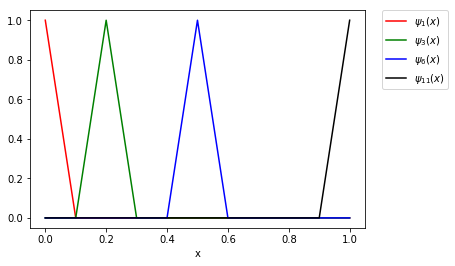

In [13]:
def LFESF(x,j,N): #define a function called LFESF (which stands for linear finite element shape function)
    Xj=(j-1)/(N-1) #define X_j
    Xjminus=(j-2)/(N-1) #define X_{j-1}
    Xjplus=j/(N-1) #define X_{j+1}
    if x<Xjminus:
        output=0.0
    else:
        if x<Xj:
            output=(x-Xjminus)/(Xj-Xjminus)
        else:
            if x<Xjplus:
                output=(Xjplus-x)/(Xjplus-Xj)
            else:
                output=0.0
    return output

def LFESFVector(x,j,N): #a version of the above that accepts a vector as the input
    output=np.zeros(len(x))
    for xj in range(len(x)): 
        output[xj]=LFESF(x[xj],j,N)
    return output

plt.plot(x,LFESFVector(x,1,11),'-r', label="$\psi_1(x)$"); #plot psi_1(x)
plt.plot(x,LFESFVector(x,3,11),'-g', label="$\psi_3(x)$") #plot psi_3(x)
plt.plot(x,LFESFVector(x,6,11),'-b', label="$\psi_6(x)$") #plot psi_6(x)
plt.plot(x,LFESFVector(x,11,11),'-k', label="$\psi_{11}(x)$") #plot psi_11(x)
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

These shape functions have some very nice properties:

1. It is very easy to construct a function $u_p(x)$ that satisfies the boundary conditions using these functions: $$u_p(x)=g_0\psi_1(x)+g_1\psi_N(x).$$
2. They make it very easy to interpret the coefficients in series expansions. If we consider the expansion of a function $v(x)$ truncated after $N$ terms: $$v(x)=\sum_{j=1}^\infty V_j\psi_j(x),$$ then now the $V_j$ have a very clear interpretation - they are the values of $v(x)$ at node $j$.
3. The functions $\psi_2(x)$, $\psi_3(x)$, ... $\psi_{N-1}(x)$ all vanish on the boundaries.
4. The resulting Jacobian matrix is sparse - for Problem P1 Weak, it is tri-diagonal, i.e. of the form $$\text{J}=\left(\begin{array}{ccccc}
J_{11} & J_{12} & 0 & 0 & 0 \\
J_{21} & J_{22} & J_{23} & 0 & 0 \\
0 & J_{32} & J_{33} & J_{34} & 0 \\
0 & 0 & J_{43} & J_{44} & J_{45} \\
0 & 0 & 0 & J_{54} & J_{55}
\end{array}\right).$$

We are now ready to solve Problem P1 Weak using the finite element method. Here is an algorithm that does this:

#### Algorithm 2: The finite element method

1. Choose the number of nodal points $N$ and distribute them evenly through the domain so that $X_j=(j-1)/h$, where $h=1/(N-1)$.
2. Set $$u_p(x)=g_0\psi_1(x)+g_1\psi_N(x)$$ and $$u_h(x)=\sum_2^{N-1}U_j\psi_j(x).$$
3. Provide an initial guess for the unknowns $U_2$, $U_3$, ... $U_{N-1}$.
4. Evaluate the residuals $r_k$ and calculate the Jacobian matrix.
5. Solve the linear system $$\sum_{j=2}^{N-1}J_{kj}\delta U_j=-r_k$$ for the $\delta U_j$.
6. Correct the initial guess via $$U_j=U_j+\delta U_j$$ and repeat until the resiuals are smaller than a specified tolerance.
7. The finite element solution is $$u^\text{(FE)}(x)=g_0\psi_1(x)+g_1\psi_N(x)+\sum_2^{N-1}U_j\psi_j(x).$$

#### An Aside:

We note that the residuals for Problem P1 Weak in the finite element formulation are given by

$$r_k(U_1,U_2,...)=\int_0^1\left(\frac{d^2u_p(x)}{dx^2}+\sum_{j=2}^{N-1}U_j\frac{d^2\psi_j(x)}{dx^2}-f(x)\right)\psi_k(x)dx\hspace{1cm}\text{for}\hspace{1cm}k=2,3,...,N-1$$

and that therefore the Jacobian matrix is given by

$$J_{kj}=\frac{\partial r_k}{\partial U_j}=\int_0^1\frac{\partial^2\psi_j(x)}{\partial x^2}\psi_k(x)dx,\hspace{1cm}\text{for}\hspace{1cm}j,k=2,3,...,N-1.$$

The first derivatives of the linear finite element shape function are relatively easy to calculate:

$$\frac{\partial\psi_j(x)}{\partial x}=\left\{\begin{array}{ll}
0 & \text{for}\hspace{0.5cm}x<X_{j-1}\\
\frac{1}{X_j-X_{j-1}} & \text{for}\hspace{0.5cm}X_{j-1}<x<X_j\\
\frac{-1}{X_{j+1}-X_j} & \text{for}\hspace{0.5cm}X_j<x<X_{j+1}\\
0 & \text{for}\hspace{0.5cm}x>X_{j+1}
\end{array}\right.$$

and plot:

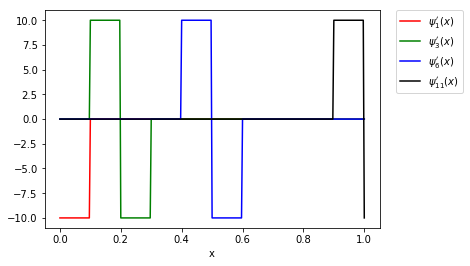

In [14]:
def DLFESF(x,j,N): #define a function called LFESF (which stands for linear finite element shape function)
    Xj=(j-1)/(N-1) #define X_j
    Xjminus=(j-2)/(N-1) #define X_{j-1}
    Xjplus=j/(N-1) #define X_{j+1}
    if x<Xjminus:
        output=0.0
    else:
        if x<Xj:
            output=1/(Xj-Xjminus)
        else:
            if x<Xjplus:
                output=-1/(Xjplus-Xj)
            else:
                output=0.0
    return output

def DLFESFVector(x,j,N): #a version of the above that accepts a vector as the input
    output=np.zeros(len(x))
    for xj in range(len(x)): 
        output[xj]=DLFESF(x[xj],j,N)
    return output

plt.plot(x,DLFESFVector(x,1,11),'-r', label="$\psi_1^\prime(x)$"); #plot psi_1'(x)
plt.plot(x,DLFESFVector(x,3,11),'-g', label="$\psi_3^\prime(x)$") #plot psi_3'(x)
plt.plot(x,DLFESFVector(x,6,11),'-b', label="$\psi_6^\prime(x)$") #plot psi_6'(x)
plt.plot(x,DLFESFVector(x,11,11),'-k', label="$\psi_{11}^\prime(x)$") #plot psi_11'(x)
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

However, the second derivatives of the linear finite element shape functions are harder to calculate due to the jumps in the first derivative. To get round this, we can use integration by parts to give:

$$J_{kj}=\left[\frac{\partial\psi_j(x)}{\partial x}\psi_k(x)\right]_0^1-\int_0^1\frac{\partial\psi_j(x)}{\partial x}\frac{\partial\psi_k(x)}{\partial x}dx,\hspace{1cm}\text{for}\hspace{1cm}j,k=2,3,...,N-1,$$

and since $\psi_j(0)=\psi_j(1)=0$ for $j=2,3,...,N-1$, the first expression on the right side is zero, so that

$$J_{kj}=-\int_0^1\frac{\partial\psi_j(x)}{\partial x}\frac{\partial\psi_k(x)}{\partial x}dx,\hspace{1cm}\text{for}\hspace{1cm}j=2,3,...,N-1.$$

We can also use the same trick to write the residuals as

$$r_k(U_1,U_2,...)=-\int_0^1\left(\frac{du_p(x)}{dx}\frac{\partial\psi_k(x)}{\partial x}+\sum_{j=2}^{N-1}U_j\frac{\partial\psi_j(x)}{\partial x}\frac{\partial\psi_k(x)}{\partial x}+f(x)\psi_k(x)\right)dx\hspace{1cm}\text{for}\hspace{1cm}k=2,3,...,N-1.$$

Now let's use this form to implement Algorithm 2 in Python to solve Problem P1 Weak over the range $x=0$ to $x=1$, with $f(x)=6x$, $u(0)=g_0=300$, $u(1)=g_1=299$ and $N=10$:

In [ ]:
#Algorithm 2 Step 1:

N=10 #the number of nodal points is 10

#Algorithm 2 Step 2:
U=np.ones(N-2) #set some initial guesses for the constants Uj - we only need U to have length N-2 since j ranges between 2 and N-1

#Algorithm 2 Step 3:
g0=300 #left boundary condtion
g1=299 #right boundary condition

def up(x): #define a function up that gives the particular solution that satisfies the boundary conditions
    output=g0*LFESF(x,1,N)+g1*LFESF(x,N,N) #the function is given in terms of the linear finite element shape functions at either end of the domain
    return output

def Dup(x): #define a function up that gives the derivative of the particular solution
    output=g0*DLFESF(x,1,N)+g1*DLFESF(x,N,N) #the function is given in terms of the derivatives of the linear finite element shape functions at either end of the domain
    return output

def uh(x,U):  #define a function uh that gives the solution that satisfies homogeneous boundary conditions
    output=np.zeros(len(x)) #first we set the output up to have the right length
    LFESFList=np.zeros(len(U)) #and we make sure the list of linear finite element shape functions has the right length
    for xj in range(len(x)): #for each input x value...
        for k in range(len(U)): #and each entry in the list of consants U...
            LFESFList[k]=LFESF(x[xj],k+2,N) #we calculate the value of the associated linear finite element shape function
        output[xj]=sum(U*LFESFList) #and output the constants times the shape functions
    return output #and return the output

#Set up while loop
tol=0.0000001 #the tolerance is 0.0000001
maxres=tol+1 
while (maxres>tol):

#Algorithm 2 Step 4:
    r=np.zeros(N-2)
    myint=np.zeros(N-2)
    Nrange=range(N-2)
    for k in Nrange: 
        for j in Nrange: 
            myint[j]=integrate.quad(lambda x: U[j]*DLFESF(x,j+2,N)*DLFESF(x,k+2,N),0,1,limit=100)[0]
        r[k]=-(integrate.quad(lambda x: Dup(x)*DLFESF(x,k+2,N),0,1,limit=100)[0]+sum(myint)+integrate.quad(lambda x: 6*x*LFESF(x,k+2,N),0,1,limit=100)[0]) 
    maxres=max(abs(r))

#Algorithm 2 Steps 5:    
    J=np.zeros((N-2,N-2))
    for j in range(N-2): 
        for k in range(N-2): 
            J[k,j]=-integrate.quad(lambda x: DLFESF(x,j+2,N)*DLFESF(x,k+2,N),0,1,limit=100)[0]
    deltaU=np.linalg.solve(J,-r) #this step solves the matrix equation J.deltaU=-r for deltaU
        
#Algorithm 2 Step 6:        
    U=U+deltaU
    
#Algorithm 2 Step 7:  
def FinalU(x,U):
    output=np.zeros(len(x))
    LFESFList=np.zeros(len(U)) #and we make sure the list of linear finite element shape functions has the right length
    for xj in range(len(x)): 
        for k in range(len(U)): 
             LFESFList[k]=LFESF(x[xj],k+2,N) #we calculate the value of the associated linear finite element shape function
        output[xj]=up(x[xj])+sum(U*LFESFList) #we have changed our particular solution to Up(x)=1+x
    return output

x=np.linspace(0,1,301)

plt.plot(x,x**3-2*x+300,'-b', label="$x^3-2x+300$") #plot f(x)=x^3-2x+300
plt.plot(x,FinalU(x,U),'--r', label="Numerical solution") #plot numerical solution
plt.xlabel('x') #label horizontal axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #plot legend

Note, if you make $N$ too large in the code above (i.e. $N\ge15$) you will start getting some numerical errors and your finite element solution will be wrong. This is likely due to numerical inaccuracies in solving the matrix equation to determine the $\delta U_j$. There are ways round this (and commercial finite element software should hopefully not have problems like this!) but they are beyond the scope of this course. This does illustrate, however, that you should not always blindly trust the output of an algorithm - it is important to know how they work and what could be going wrong before you decide that the solution is acceptable.

#### <span style="color: red"> Task 10:</span> Solve Poisson's equation with $f(x)=20\sin(2x)$, $u(0)=g_0=300$, $u(1)=g_1=299$ and $N=10$ using the finite element method

Compare your numerical solution to the exact solution:

$$u(x)=300-x+5x\sin(2)-5\sin(2x).$$

Hint: All you need to do is edit the code above to change $f(x)$ from $6x$ to $20\sin(2x)$.

The figure you obtain should look like this:
<figure>
<img src="Figures/05_T10.jpg" width='400'>
</figure>